In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp
import pprint

from fusiondls.Profile import *
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [5]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [6]:
curves = {}
T = np.linspace(0, 1000, 1000)

## radas

In [7]:
rd = dict(
    Ar = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc"),
    Ne = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\neon.nc"),
    N = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\nitrogen.nc")    
)

for species in rd.keys():
    curves[species] = {}
    ds = rd[species]

    for netau in ds.coords["dim_ne_tau"].values:
        rate = ds["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
        netau_name = netau
        curves[species][netau_name*1e3] = sp.interpolate.interp1d(
            ds.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
            fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
            )


## SOLPS

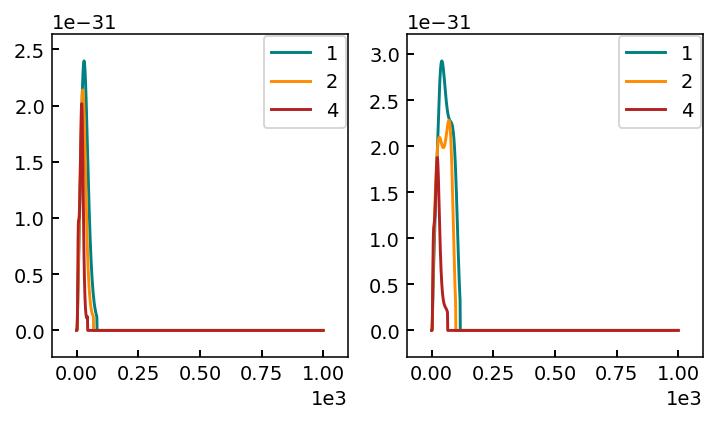

In [8]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


## Custom

In [9]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

In [10]:
curves["Ar"].keys()

dict_keys([1e+18, 1e+19, 1e+20, 1e+21, 1e+22, 1e+23, 1e+24, 1e+25, 9.999999999999999e+25, 1e+27])

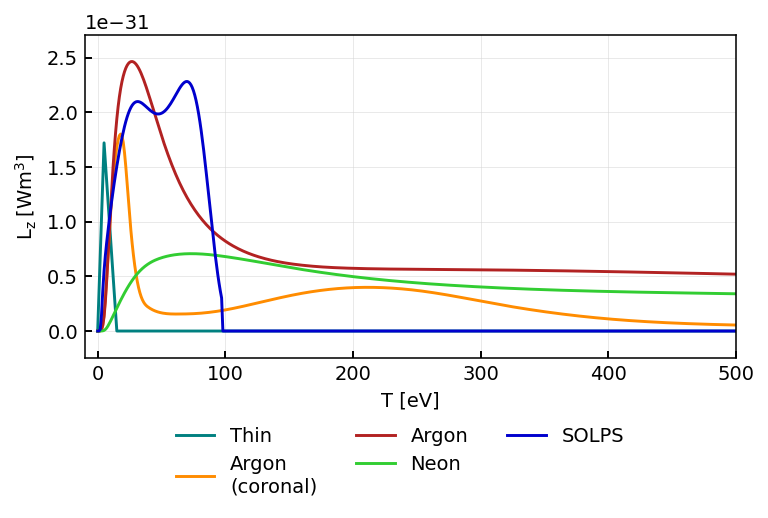

In [11]:
netau = 1e19

curves["set_outer"] = {
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    # "Nitrogen 1e19" : curves["N"][netau],
    "Argon\n(coronal)" : curves["Ar"][1e23],
    "Argon" : curves["Ar"][netau],
    "Neon" : curves["Ne"][netau],
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],    
    
    # "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    # "Curve 2" : curves["Ar"][1e16*1e3],
    # "Curve 3" : curves["Ar"][1e14*1e3],
    # "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
}
    
fig, ax = plt.subplots(figsize = (6,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    # Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"$L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 3, frameon = False)
ax.set_xlim(-10,500)
ax.grid()
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_outer.pdf", format = "pdf")

### Inner

In [12]:
sepadd_select

{'outer_lower': 2, 'inner_lower': 1}

(-10.0, 200.0)

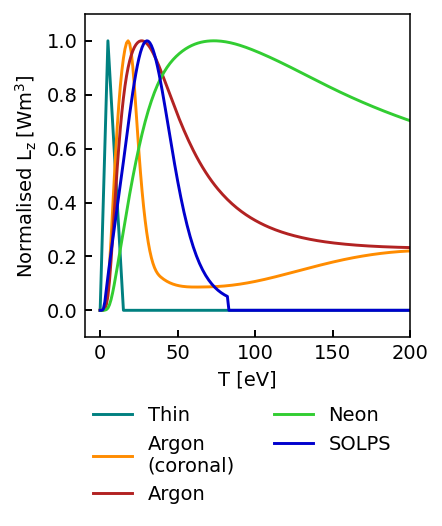

In [13]:
curves["set_inner"] = {
    
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Argon\n(coronal)" : curves["Ar"][1e23],
    "Argon" : curves["Ar"][netau],
    # "Nitrogen 1e19" : curves["N"][netau],
    "Neon" : curves["Ne"][netau],
    "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],    
} 
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_inner"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_inner.pdf", format = "pdf")

# Outer profiles

In [14]:
store_profiles = {}
store_profiles["outer"] = {}
store_profiles["inner"] = {}

## f_R

In [15]:
p = eqb[case]["outer_lower"][sepadd_select["outer_lower"]]
base_profile = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

Text(0.5, 1.0, 'Flux expansion profiles')

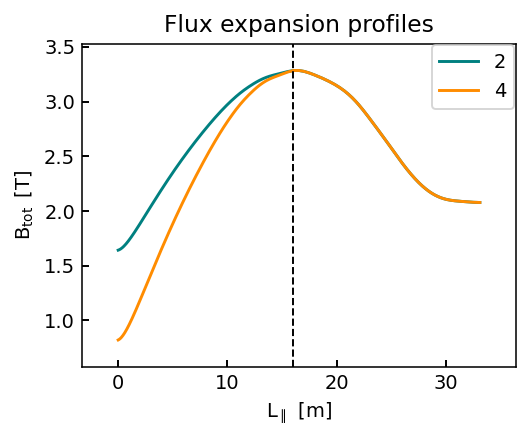

In [16]:
list_fR = [2, 4]
store_profiles["outer"]["fR"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for fR in list_fR:
    store_profiles["outer"]["fR"][fR] = copy.deepcopy(base_profile)
    store_profiles["outer"]["fR"][fR].scale_BxBt(BxBt = fR)
    
    ax.plot(store_profiles["outer"]["fR"][fR]["S"], store_profiles["outer"]["fR"][fR]["Btot"], label = fR)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["S"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel(r"$L_{\parallel}\ \ [m]$")
ax.set_ylabel(r"$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Lc

Text(0.5, 1.0, 'Flux expansion profiles')

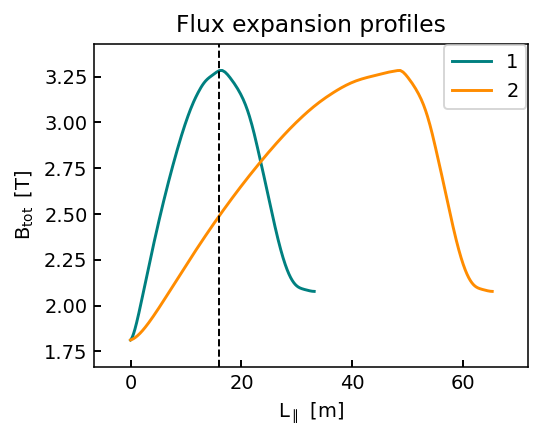

In [17]:
list_Lc_factors = [1, 2]
store_profiles["outer"]["Lc"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for Lc_factor in list_Lc_factors:
    store_profiles["outer"]["Lc"][Lc_factor] = copy.deepcopy(base_profile)
    store_profiles["outer"]["Lc"][Lc_factor].scale_Lc(scale_factor = Lc_factor)
    
    ax.plot(store_profiles["outer"]["Lc"][Lc_factor]["S"], store_profiles["outer"]["Lc"][Lc_factor]["Btot"], label = Lc_factor)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["S"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel(r"$L_{\parallel}\ \ [m]$")
ax.set_ylabel(r"$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Paper profile plot

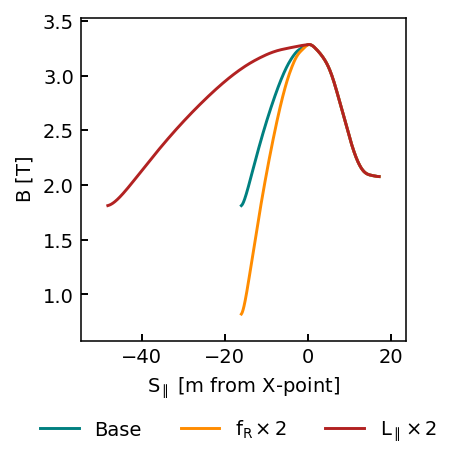

In [18]:
fig, ax = plt.subplots(figsize = (3,3))

profiles = dict(
    base = base_profile,
    fR = store_profiles["outer"]["fR"][4],
    Lc = store_profiles["outer"]["Lc"][2]
)

Sx = profiles["base"]["S"][profiles["base"]["Xpoint"]]

ax.plot(profiles["base"]["S"] - profiles["base"]["S"][profiles["base"]["Xpoint"]], profiles["base"]["Btot"], label = "Base")
ax.plot(profiles["fR"]["S"] - profiles["fR"]["S"][profiles["fR"]["Xpoint"]], profiles["fR"]["Btot"], label = r"$f_{R} \times 2$")
ax.plot(profiles["Lc"]["S"] - profiles["Lc"]["S"][profiles["Lc"]["Xpoint"]],  profiles["Lc"]["Btot"], label = r"$L_{\parallel} \times 2$")

ax.set_xlabel(r"$S_{\parallel}$ [m from X-point]")
ax.set_ylabel(r"$B$ [T]")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.05), ncols = 3, frameon = False)

# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_profiles_outer.pdf", format = "pdf")

# Inner profiles

## f_R

In [19]:
p = eqb[case]["inner_lower"][sepadd_select["inner_lower"]]
base_profile = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

Text(0.5, 1.0, 'Flux expansion profiles')

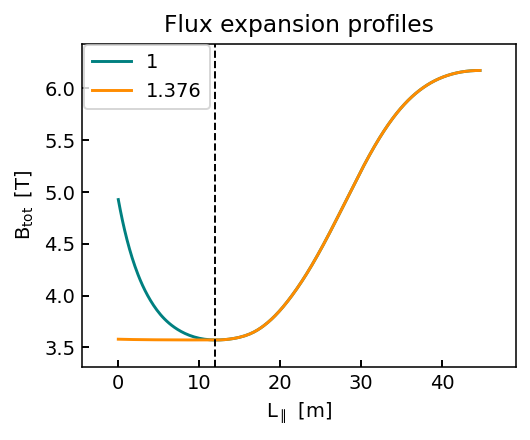

In [20]:
list_fR_factors = [1,1.376]
store_profiles["inner"]["fR"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for fR in list_fR_factors:
    store_profiles["inner"]["fR"][fR] = copy.deepcopy(base_profile)
    store_profiles["inner"]["fR"][fR].scale_BxBt(scale_factor = fR)
    
    ax.plot(store_profiles["inner"]["fR"][fR]["S"], store_profiles["inner"]["fR"][fR]["Btot"], label = fR)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["S"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel(r"$L_{\parallel}\ \ [m]$")
ax.set_ylabel(r"$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Lc

Text(0.5, 1.0, 'Flux expansion profiles')

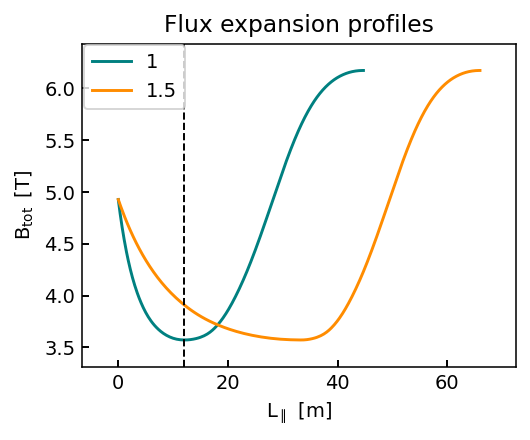

In [21]:
list_Lc_factors = [1, 1.5]
store_profiles["inner"]["Lc"] = {}

fig, ax = plt.subplots(figsize = (4,3))

for Lc_factor in list_Lc_factors:
    store_profiles["inner"]["Lc"][Lc_factor] = copy.deepcopy(base_profile)
    store_profiles["inner"]["Lc"][Lc_factor].scale_Lc(scale_factor = Lc_factor)
    
    ax.plot(store_profiles["inner"]["Lc"][Lc_factor]["S"], store_profiles["inner"]["Lc"][Lc_factor]["Btot"], label = Lc_factor)
    
ylims = ax.get_ylim()
ax.vlines(base_profile["S"][base_profile["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel(r"$L_{\parallel}\ \ [m]$")
ax.set_ylabel(r"$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Paper profile plot

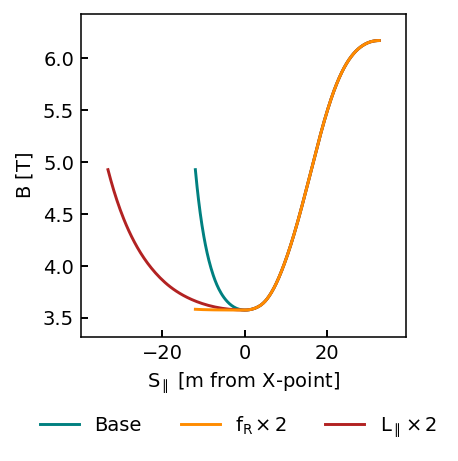

In [22]:
fig, ax = plt.subplots(figsize = (3,3))

profiles = dict(
    base = base_profile,
    fR = store_profiles["inner"]["fR"][list_fR_factors[-1]],
    Lc = store_profiles["inner"]["Lc"][list_Lc_factors[-1]]
)

Sx = profiles["base"]["S"][profiles["base"]["Xpoint"]]

ax.plot(profiles["base"]["S"] - profiles["base"]["S"][profiles["base"]["Xpoint"]], profiles["base"]["Btot"], label = "Base")
ax.plot(profiles["fR"]["S"] - profiles["fR"]["S"][profiles["fR"]["Xpoint"]], profiles["fR"]["Btot"], label = r"$f_{R} \times 2$", zorder = 50)
ax.plot(profiles["Lc"]["S"] - profiles["Lc"]["S"][profiles["Lc"]["Xpoint"]],  profiles["Lc"]["Btot"], label = r"$L_{\parallel} \times 2$")

ax.set_xlabel(r"$S_{\parallel}$ [m from X-point]")
ax.set_ylabel(r"$B$ [T]")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.05), ncols = 3, frameon = False)

# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_profiles_inner.pdf", format = "pdf")

# DLS run definition

In [23]:
def run_DLS(custom_inputs, profile, Spar, slc, cvar, region, sepadd, hflux_corr=1):
    ## Get SOLPS field line and max qpar
    df = slc.get_1d_poloidal_data(
        params=["fhx_total", "Ne"], sepadd=sepadd, region=region, target_first=True
    )
    qpar_max = (df["fhx_total"] / df["apar"]).abs().max()
    
    if Spar == "auto":
        SparRange=[
            slc.extract_front_pos(
                sepadd=sepadd,
                region=region,
                impurity="Ar",
                method="qpar_tot",
                threshold=0.05,
            )
        ]
    else:
        SparRange = Spar
        
        

    ## Input deck
    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange = SparRange,
        qpllu0=qpar_max * hflux_corr,
        nu0=df["Ne"].iloc[-1],
        cz0=0.05,
        cooling_curve=slc.extract_cooling_curve("Ar", region, sepadd=sepadd, plot=False),
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        grid_refinement_ratio=5,
        grid_refinement_width=2,
        grid_resolution=10000,
    )

    try:
        out = run_dls(
            dataclasses.replace(inputs, **custom_inputs),
            MagneticGeometry.from_profile(profile),
        )
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(slc, out, cvar, impurity = "Ar", region = region, sepadd = sepadd)

def get_correction_factors(comp):
    fhx_solps = comp.solps[comp.solps["Xpoint"] == 1]["fhx_total"].abs().values[0]
    fhx_dls = comp.dls[comp.dls["Xpoint"] == 1]["qpar"].values[0]
    hflux_factor = fhx_solps / fhx_dls

    kappa_factor = (comp.dls["Te"].max() / comp.solps["Te"].max()) ** 2

    return hflux_factor, kappa_factor

comps_outer = {}
store_outer = {}
comps_inner = {}
store_inner = {}

In [24]:
region = "outer_lower"
slc = store_slc[case]

# Run outer

## Flux expansion

In [25]:
study = "base"
region = "outer_lower"
study = "fR"
comps_outer[study] = {}
store_outer[study] = {}

for curve in curves["set_outer"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_outer[study][curve] = {}
    store_outer[study][curve] = {}
    
    input = dict(cooling_curve = curves["set_outer"][curve])

    for i in store_profiles["outer"][study].keys():
        print(f"Solving fR {i} ------")
        out, comp = run_DLS(input, store_profiles["outer"]["fR"][i], [0], store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_outer[study][curve][i] = comp
        store_outer[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Thin ------
Solving fR 2 ------
Solving...0.00...Complete in 2.9 seconds
Solving fR 4 ------
Solving...0.00...Complete in 3.7 seconds
Solving curve Argon
(coronal) ------
Solving fR 2 ------
Solving...0.00...Complete in 1.9 seconds
Solving fR 4 ------
Solving...0.00...Complete in 5.4 seconds
Solving curve Argon ------
Solving fR 2 ------
Solving...0.00...Complete in 5.3 seconds
Solving fR 4 ------
Solving...0.00...Complete in 5.4 seconds
Solving curve Neon ------
Solving fR 2 ------
Solving...0.00...Complete in 4.8 seconds
Solving fR 4 ------
Solving...0.00...Complete in 3.7 seconds
Solving curve SOLPS ------
Solving fR 2 ------
Solving...0.00...Complete in 4.0 seconds
Solving fR 4 ------
Solving...0.00...Complete in 3.5 seconds


## Connection length

In [26]:
study = "base"
region = "outer_lower"
study = "Lc"
comps_outer[study] = {}
store_outer[study] = {}

for curve in curves["set_outer"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_outer[study][curve] = {}
    store_outer[study][curve] = {}
    
    input = dict(cooling_curve = curves["set_outer"][curve])

    for i in store_profiles["outer"][study].keys():
        print(f"Solving {study} {i} ------")
        out, comp = run_DLS(input, store_profiles["outer"][study][i], [0], store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_outer[study][curve][i] = comp
        store_outer[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Thin ------
Solving Lc 1 ------
Solving...0.00...Complete in 3.1 seconds
Solving Lc 2 ------
Solving...0.00...Complete in 3.1 seconds
Solving curve Argon
(coronal) ------
Solving Lc 1 ------
Solving...0.00...Complete in 3.6 seconds
Solving Lc 2 ------
Solving...0.00...Complete in 4.2 seconds
Solving curve Argon ------
Solving Lc 1 ------
Solving...0.00...Complete in 4.0 seconds
Solving Lc 2 ------
Solving...0.00...Complete in 4.4 seconds
Solving curve Neon ------
Solving Lc 1 ------
Solving...0.00...Complete in 3.5 seconds
Solving Lc 2 ------
Solving...0.00...Complete in 3.9 seconds
Solving curve SOLPS ------
Solving Lc 1 ------
Solving...0.00...Complete in 3.2 seconds
Solving Lc 2 ------
Solving...0.00...Complete in 3.7 seconds


# Run inner

## Flux expansion

In [27]:
study = "base"
region = "inner_lower"
study = "fR"
comps_inner[study] = {}
store_inner[study] = {}

for curve in curves["set_inner"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_inner[study][curve] = {}
    store_inner[study][curve] = {}
    
    input = dict(
        cooling_curve = curves["set_inner"][curve],
        qpllu0 = 3.42e8 * 0.83,
        kappa0 = 2800 * 1.73,
        )

    for i in store_profiles["inner"][study].keys():
        print(f"Solving fR {i} ------")
        
        out, comp = run_DLS(input, store_profiles["inner"][study][i], [0], store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_inner[study][curve][i] = comp
        store_inner[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Thin ------
Solving fR 1 ------
Solving...0.00...Complete in 3.3 seconds
Solving fR 1.376 ------
Solving...0.00...Complete in 2.2 seconds
Solving curve Argon
(coronal) ------
Solving fR 1 ------
Solving...0.00...Complete in 4.3 seconds
Solving fR 1.376 ------
Solving...0.00...Complete in 4.5 seconds
Solving curve Argon ------
Solving fR 1 ------
Solving...0.00...Complete in 3.1 seconds
Solving fR 1.376 ------
Solving...0.00...Complete in 4.6 seconds
Solving curve Neon ------
Solving fR 1 ------
Solving...0.00...Complete in 4.4 seconds
Solving fR 1.376 ------
Solving...0.00...Complete in 4.9 seconds
Solving curve SOLPS ------
Solving fR 1 ------
Solving...0.00...Complete in 3.9 seconds
Solving fR 1.376 ------
Solving...0.00...Complete in 2.4 seconds


## Connection length

In [28]:
study = "base"
region = "inner_lower"
study = "Lc"
comps_inner[study] = {}
store_inner[study] = {}

for curve in curves["set_inner"].keys():
    
    print(f"Solving curve {curve} ------")
    
    comps_inner[study][curve] = {}
    store_inner[study][curve] = {}
    
    input = dict(
        cooling_curve = curves["set_inner"][curve],
        qpllu0 = 3.42e8 * 0.83,
        kappa0 = 2800 * 1.73,
        )

    for i in store_profiles["inner"][study].keys():
        print(f"Solving {study} {i} ------")
        out, comp = run_DLS(input, store_profiles["inner"][study][i], [0], store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_inner[study][curve][i] = comp
        store_inner[study][curve][i] = out
    
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving curve Thin ------
Solving Lc 1 ------
Solving...0.00...Complete in 3.3 seconds
Solving Lc 1.5 ------
Solving...0.00...Complete in 3.8 seconds
Solving curve Argon
(coronal) ------
Solving Lc 1 ------
Solving...0.00...Complete in 4.7 seconds
Solving Lc 1.5 ------
Solving...0.00...Complete in 2.0 seconds
Solving curve Argon ------
Solving Lc 1 ------
Solving...0.00...Complete in 3.4 seconds
Solving Lc 1.5 ------
Solving...0.00...Complete in 3.6 seconds
Solving curve Neon ------
Solving Lc 1 ------
Solving...0.00...Complete in 5.4 seconds
Solving Lc 1.5 ------
Solving...0.00...Complete in 2.0 seconds
Solving curve SOLPS ------
Solving Lc 1 ------
Solving...0.00...Complete in 3.5 seconds
Solving Lc 1.5 ------
Solving...0.00...Complete in 4.0 seconds


# Scalings breakdown - outer

## Prepare data

In [29]:
# param = "Lc"
# study_name = "Lc"

param = "BxBt"
study_name = "fR"
side = "outer"

store_choices = dict(inner = store_inner, outer = store_outer)
comps_choices = dict(inner = comps_inner, outer = comps_outer)


allchecks = {}
allterms = {}
allsc = {}
all_plotweights = {}

analytical = pd.DataFrame()

params = ["Lc", "BxBt"]
studies = ["Lc", "fR"]
# studies = ["Lc"]

for i, study in enumerate(studies):
    param = params[i]
    plot_weights = pd.DataFrame()

    for curve_name in curves[f"set_{side}"].keys():

        store = store_choices[side][study][curve_name]
        names = list(store.keys())

        sc = scaling_comparison(store[names[0]], store[names[-1]], param)
        allsc[curve_name] = sc
        allterms[curve_name] = sc.terms.copy()
        allchecks[curve_name] = sc.terms_check.copy()
        plot_weights[curve_name] = sc.terms["weights"]
        
        
    all_plotweights[study] = plot_weights
        
    ## Calculate analytical results for just Lpar/fR and for full analytical DLS with upstream and avgB ratio
    ratio = sc.terms_full["ratio"]
    param_ratio = ratio[param]
    simple = ratio["BxBt"] * ratio["Lc"]**(2/7)
    simple_avgB = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7)
    full = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7) * ratio["W_Tu_simple"]**(-1)
    
    analytical.loc["simple", study] = np.log(simple) / np.log(param_ratio)
    analytical.loc["simple_avgB", study] = np.log(simple_avgB) / np.log(param_ratio)
    analytical.loc["full", study] = np.log(full) / np.log(param_ratio)
        
analytical
    
        

,Lc,fR
simple,0.285728,1.000000
simple_avgB,0.285738,0.946836
full,0.148668,0.963044


## Prepare plot

In [32]:
bar_alpha = 0.5

# param_labels = dict(
#     Beff = r"$\alpha$: $B_{eff}$",
#     W_Tu = r"$\beta$: $\frac{Q_{in}^{2/7}}{T_{u}}$",
#     curveclip = r"$\gamma$: ${\sqrt{2\int^{T_{u}}_{T_{f}} \kappa_{e0} T^{1/2}  L_{\alpha}(T) }dT}$", 
#     upstream_rad = r"$\delta$: $\left(\sqrt{2 \int^{s=L_{||}}_{s=s_{X}} \frac{q_{||}}{Q_{in}B^{2}}ds}\right)^{-1}$"
#     )

param_labels = dict(
    Beff = r"$\alpha$: $B_{eff}$",
    W_Tu = r"$\beta$: $\frac{Q_{in}^{2/7}}{T_{u}}$",
    curveclip = r"$\gamma$: ${\sqrt{2\int^{T_{u}}_{T_{f}} \kappa_{e0} T^{1/2}  L_{\alpha}(T) }dT}$", 
    upstream_rad = r"$\delta$: $\left(\sqrt{2 \int^{s=L_{||}}_{s=s_{X}} \frac{q_{||}}{Q_{in}B^{2}}ds}\right)^{-1}$"
    )

param_colors = dict(
    Beff = "teal",
    W_Tu = "darkorange",   
    curveclip = "firebrick",
    upstream_rad = "limegreen"
)

ylabels = dict(Lc = r"$K_{L_{\parallel}}$", fR = r"$K_{f_{R}}$")
titles = dict(Lc = r"b) $L_{\parallel}$", fR = r"a) $f_{R}$")

analytical_scaling = dict(Lc = 2/7, fR = 1)

handles = []
for param in param_labels:
    handles.append(mpl.patches.Patch(color = param_colors[param], label = param_labels[param], alpha = bar_alpha*0.7, linewidth = 0))
    
handles_line = [
    mpl.lines.Line2D([], [], color = "deeppink", lw = 2, ls = ":", label = "Analytical: \n " + r"$K_{L_{\parallel}}=2/7$, $K_{f_{R}}=1$"),
    # mpl.lines.Line2D([], [], color = "black", lw = 2, ls = ":", label = "Analytical: \n" + r"Include $\frac{B_X^{2/7}}{\langle B \rangle^{2/7}_{above\ t}}$, upstream"),
    ]

## Plot for paper

## Plot for synopsis

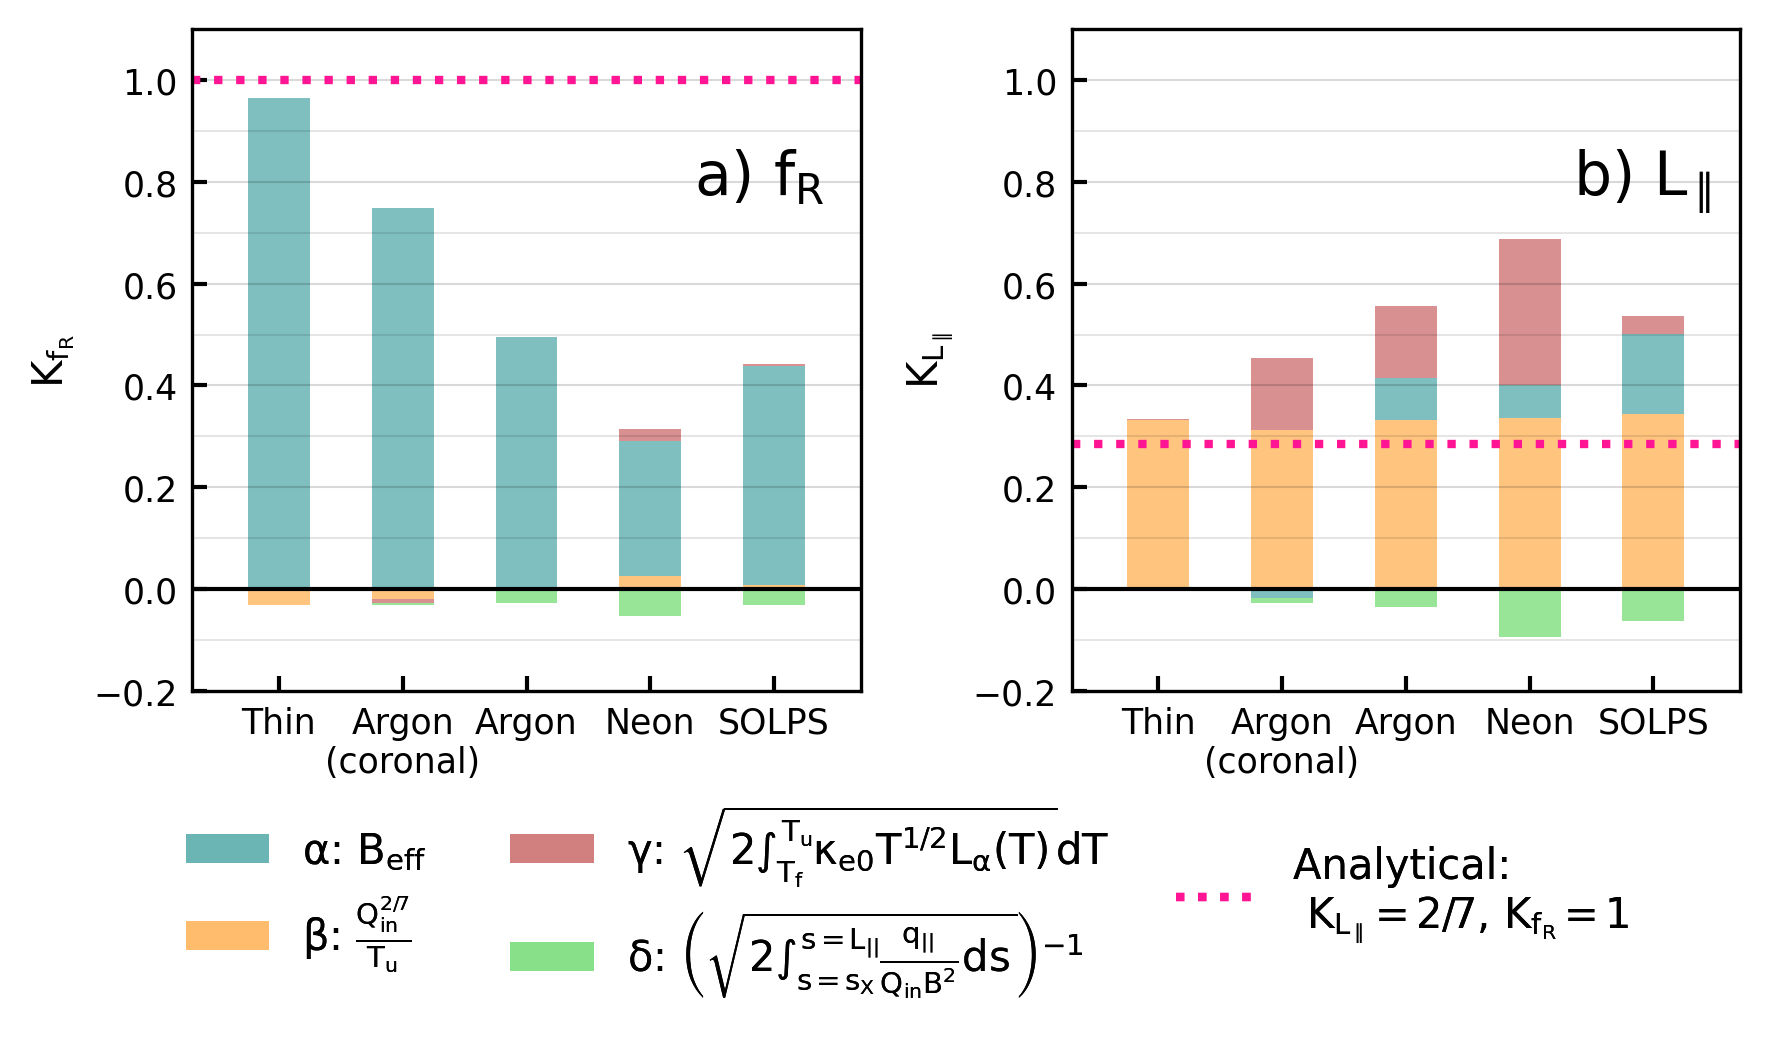

In [40]:
side = "outer"

fig, axes = plt.subplots(1,2, figsize = (6,2.8), dpi = 300)

for i, study in enumerate(studies[::-1]):
    ax = axes[i]

    plot_weights = all_plotweights[study].reindex(["W_Tu", "Beff", "curveclip", "upstream_rad"])
    weight_counts_pos = {}
    weight_counts_neg = {}
    for param in plot_weights.index:
        weight_counts_neg[param] = plot_weights[plot_weights < 0].fillna(0).loc[param, :]
        weight_counts_pos[param] = plot_weights[plot_weights > 0].fillna(0).loc[param, :]
        
    bottom_pos = np.zeros_like(weight_counts_pos[param])
    bottom_neg = np.zeros_like(weight_counts_pos[param])

    width = 0.5
    for param, weight_counts_neg in weight_counts_neg.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_neg, width, bottom = bottom_neg, alpha = bar_alpha, color = param_colors[param])
        bottom_neg += weight_counts_neg
        
    for param, weight_counts_pos in weight_counts_pos.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_pos, width, bottom = bottom_pos, alpha = bar_alpha, color = param_colors[param])
        bottom_pos += weight_counts_pos
        
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.grid(axis = "x", which = "both", visible = False)
    ax.grid(axis = "y", which = "major", c = "k", alpha = 0.15)
    ax.grid(axis = "y", which = "minor", c = "k", alpha = 0.1)
    ax.set_ylim(-0.2, 1.1)
    xlim = ax.get_xlim()
    ax.hlines(0, *xlim, color = "k", lw = 1, linestyle = "-")
    ax.set_xlim(xlim)
    
    fig.legend(handles=handles, ncols = 2, loc = "upper left", bbox_to_anchor = (0.1, 0.05), frameon = False)
    fig.legend(handles=handles_line, ncols = 1, loc = "upper left", bbox_to_anchor = (0.65, 0), frameon = False)
    ax.set_ylabel(ylabels[study])
    ax.text(0.75, 0.75, titles[study], fontsize = "x-large", transform=ax.transAxes)
    xlim = ax.get_xlim()
    
    ax.hlines(analytical.loc["simple", study], *xlim, color = "deeppink", lw = 2, linestyle = ":")
    # ax.hlines(analytical.loc["full", study], *xlim, color = "black", lw = 2, linestyle = ":")
    ax.tick_params(axis = "both", labelsize = "small")
    # ax.set_title(titles[study], loc = "right", transform=ax.transAxes)


fig.tight_layout()
# fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_K_{side}_lower.pdf", format = "pdf")

# Scalings breakdown - inner

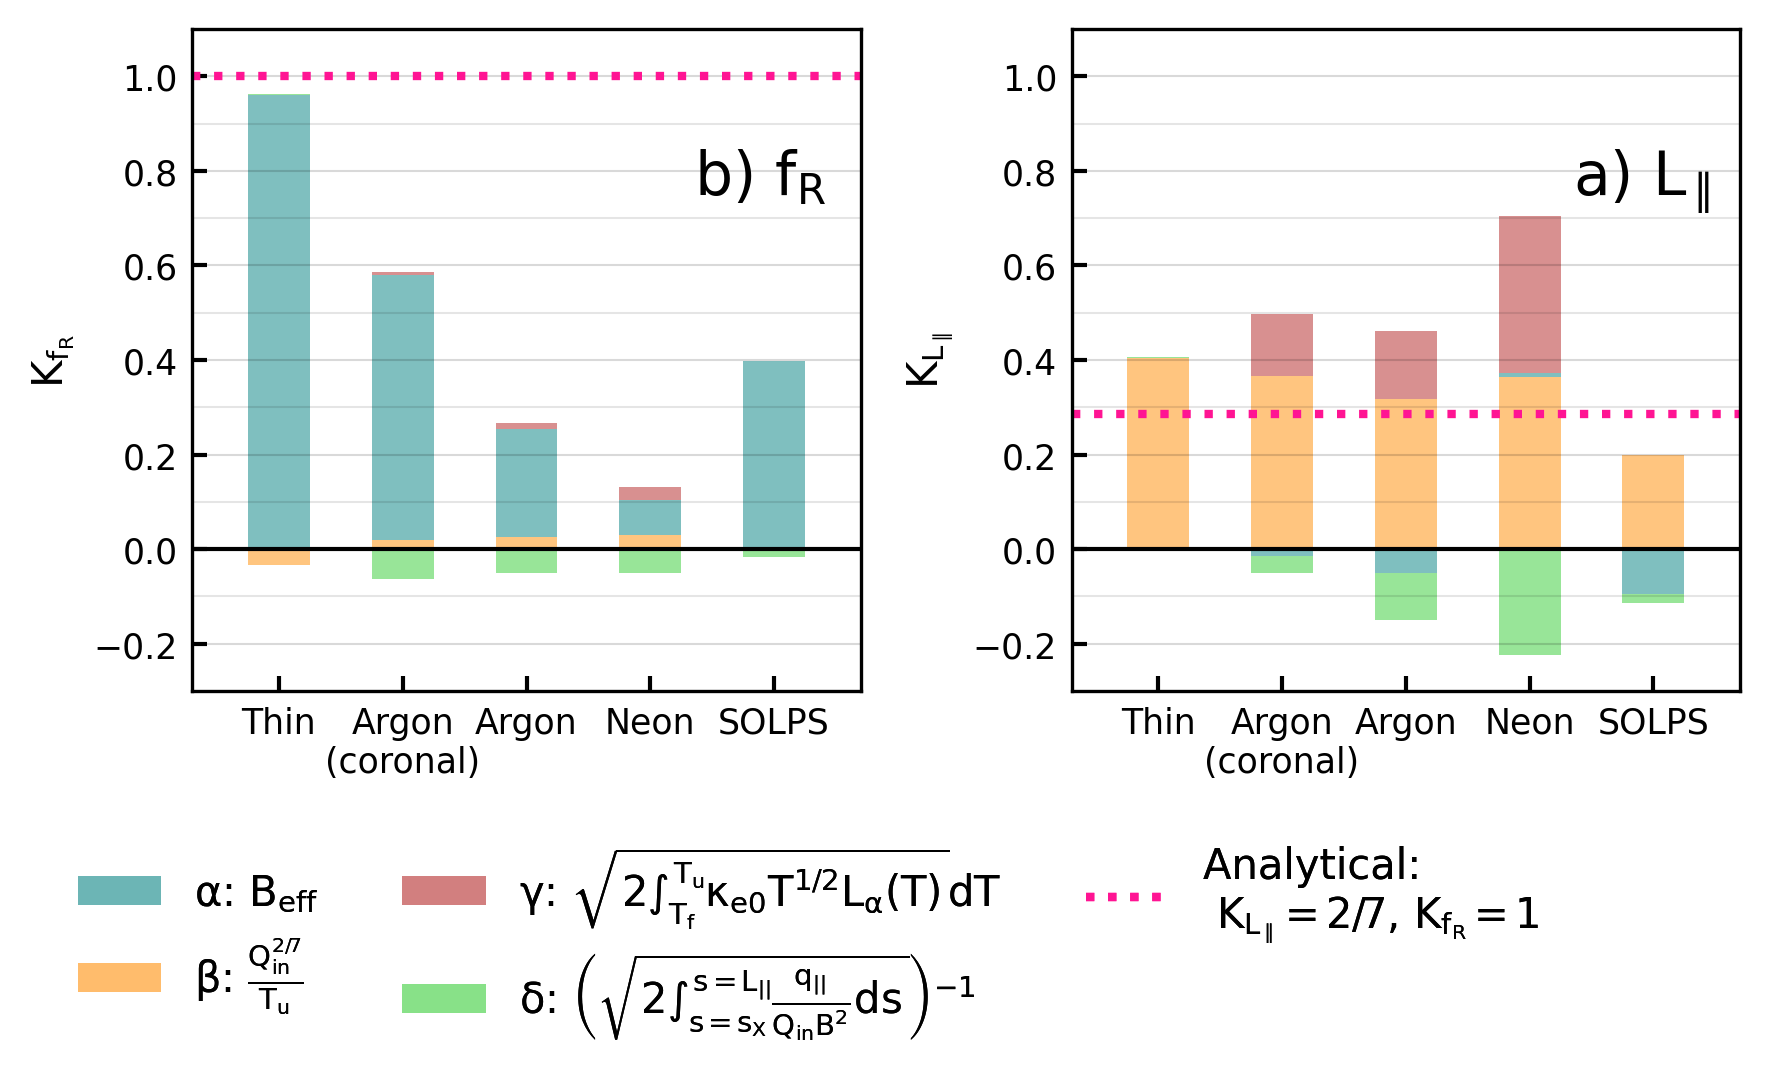

In [43]:
# param = "Lc"
# study_name = "Lc"

param = "BxBt"
study_name = "fR"
side = "inner"

store_choices = dict(inner = store_inner, outer = store_outer)
comps_choices = dict(inner = comps_inner, outer = comps_outer)


allchecks = {}
allterms = {}
allsc = {}
all_plotweights = {}

analytical = pd.DataFrame()

params = ["Lc", "BxBt"]
studies = ["Lc", "fR"]
# studies = ["Lc"]
all_allsc = {}

for i, study in enumerate(studies):
    param = params[i]
    plot_weights = pd.DataFrame()
    all_allsc[study] = {}

    for curve_name in curves[f"set_{side}"].keys():

        store = store_choices[side][study][curve_name]
        names = list(store.keys())

        sc = scaling_comparison(store[names[0]], store[names[-1]], param)
        allsc[curve_name] = sc
        all_allsc[study][curve_name] = sc
        allterms[curve_name] = sc.terms.copy()
        allchecks[curve_name] = sc.terms_check.copy()
        plot_weights[curve_name] = sc.terms["weights"]
        
        
    all_plotweights[study] = plot_weights
        
    ## Calculate analytical results for just Lpar/fR and for full analytical DLS with upstream and avgB ratio
    ratio = sc.terms_full["ratio"]
    param_ratio = ratio[param]
    simple = ratio["BxBt"] * ratio["Lc"]**(2/7)
    simple_avgB = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7)
    full = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7) * ratio["W_Tu_simple"]**(-1)
    
    analytical.loc["simple", study] = np.log(simple) / np.log(param_ratio)
    analytical.loc["simple_avgB", study] = np.log(simple_avgB) / np.log(param_ratio)
    analytical.loc["full", study] = np.log(full) / np.log(param_ratio)
        
fig, axes = plt.subplots(1,2, figsize = (6,2.8), dpi = 300)

for i, study in enumerate(studies[::-1]):
    ax = axes[i]

    plot_weights = all_plotweights[study].reindex(["W_Tu", "Beff", "curveclip", "upstream_rad"])
    weight_counts_pos = {}
    weight_counts_neg = {}
    for param in plot_weights.index:
        weight_counts_neg[param] = plot_weights[plot_weights < 0].fillna(0).loc[param, :]
        weight_counts_pos[param] = plot_weights[plot_weights > 0].fillna(0).loc[param, :]
        
    bottom_pos = np.zeros_like(weight_counts_pos[param])
    bottom_neg = np.zeros_like(weight_counts_pos[param])

    width = 0.5
    for param, weight_counts_neg in weight_counts_neg.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_neg, width, bottom = bottom_neg, alpha = bar_alpha, color = param_colors[param])
        bottom_neg += weight_counts_neg
        
    for param, weight_counts_pos in weight_counts_pos.items():
        p = ax.bar(curves[f"set_{side}"].keys(), weight_counts_pos, width, bottom = bottom_pos, alpha = bar_alpha, color = param_colors[param])
        bottom_pos += weight_counts_pos
        
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.grid(axis = "x", which = "both", visible = False)
    ax.grid(axis = "y", which = "major", c = "k", alpha = 0.15)
    ax.grid(axis = "y", which = "minor", c = "k", alpha = 0.1)
    ax.set_ylim(-0.3, 1.1)
    xlim = ax.get_xlim()
    ax.hlines(0, *xlim, color = "k", lw = 1, linestyle = "-")
    ax.set_xlim(xlim)
    
    fig.legend(handles=handles, ncols = 2, loc = "upper left", bbox_to_anchor = (0.04, 0.0), frameon = False)
    fig.legend(handles=handles_line, ncols = 1, loc = "upper left", bbox_to_anchor = (0.6, 0), frameon = False)
    ax.set_ylabel(ylabels[study])
    ax.text(0.75, 0.75, titles[study], fontsize = "x-large", transform=ax.transAxes)
    xlim = ax.get_xlim()
    
    ax.hlines(analytical.loc["simple", study], *xlim, color = "deeppink", lw = 2, linestyle = ":")
    # ax.hlines(analytical.loc["full", study], *xlim, color = "black", lw = 2, linestyle = ":")
    ax.tick_params(axis = "both", labelsize = "small")
    # ax.set_title(titles[study], loc = "right", transform=ax.transAxes)


fig.tight_layout()
# fig.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_K_{side}_lower.pdf", format = "pdf")
        

In [34]:
# study = "fR"

sc = all_allsc["fR"]["Thin"]
terms = sc.terms_full
terms.loc["1/cvar"] = 1/terms.loc["cvar"]
ratio = terms["ratio"]
ratio_full = ratio["BxBt"] * ratio["Lc"]**(2/7) * ratio["avgB_ratio"]**(-2/7) * ratio["W_Tu_simple"]**(1)
print(ratio_full)

0.7465567419675163


In [135]:
terms

,base,test,ratio
cvar,9.935268e+19,8.522167e+19,1.165815
kappa0,4.844000e+03,4.844000e+03,1.000000
Bf,4.925754e+00,3.579763e+00,1.376000
Bx,3.572338e+00,3.572345e+00,0.999998
Beff,4.184267e+00,3.575696e+00,1.170197
BxBt,7.252368e-01,9.979277e-01,0.726743
BxBteff,8.537548e-01,9.990628e-01,0.854556
Lc,5.260645e+00,5.260645e+00,1.000000
Wradial,1.141393e+07,1.141391e+07,1.000001
Tu,8.474279e+01,8.427899e+01,1.005503


In [35]:

# terms.loc["1/cvar"] = 1/terms.loc["cvar"]

terms.loc[["1/cvar", "BxBt", "Lc"]]

,base,test,ratio
1/cvar,1.006515e-20,1.173410e-20,0.857769
BxBt,7.252368e-01,9.979277e-01,0.726743
Lc,5.260645e+00,5.260645e+00,1.000000


In [139]:
np.log(ratio["1/cvar"]) / np.log(ratio["BxBt"])

0.48066611923847485

In [113]:
comps_inner["fR"]["Thin"].keys()

dict_keys([1, 1.376])

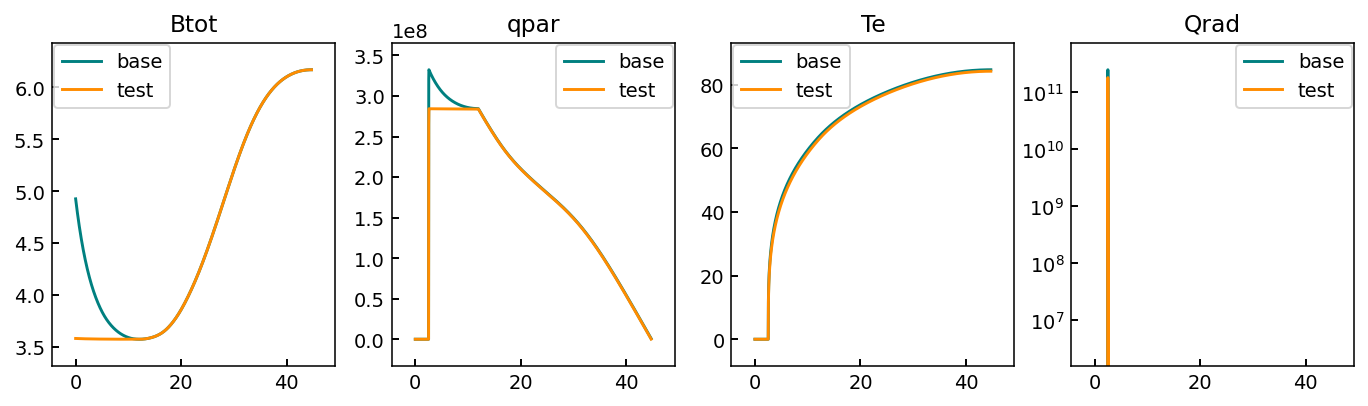

In [114]:
            
toplot = dict(
    base = comps_inner["fR"]["Thin"][1].dls,
    test = comps_inner["fR"]["Thin"][1.376].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

# Visualising terms

In [35]:
cases = {
    "Thin curve": FrontLocation(store_outer["fR"]["Thin"][2]),
    "Neon curve": FrontLocation(store_outer["fR"]["Neon"][2]),
}


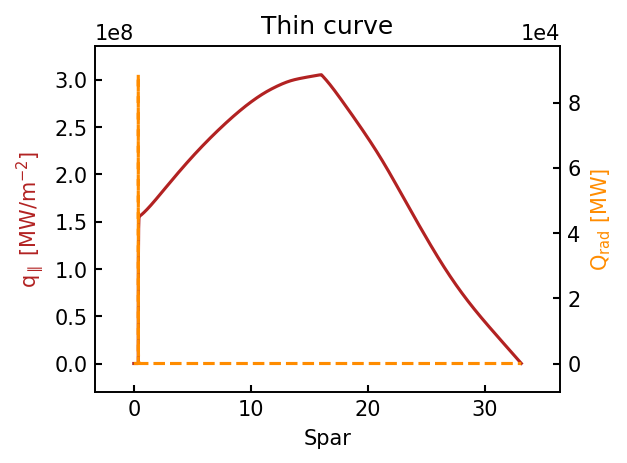

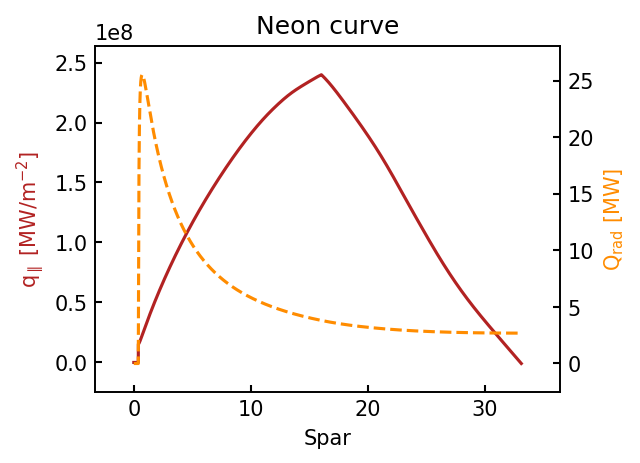

In [197]:
for name, out in cases.items():
    dls = out.data
    fig, ax = plt.subplots(figsize = (4,3), dpi = 150)
    ax.plot(dls["Spar"], dls["qpar"], c = "firebrick", label = r"$B_{tot}$ [T]")
    ax2 = ax.twinx()
    ax2.plot(dls["Spar"], dls["Qrad"]*1e-6, ls = "--", color = "darkorange", label = r"$Q_{rad}$")
    # fig.legend(loc = "upper left", bbox_to_anchor = (0.65,0.85))
    ax.set_xlabel("Spar")
    ax.set_ylabel(r"$q_{\parallel}$ [MW/$m^{-2}$]", color = "firebrick")
    ax2.set_ylabel("$Q_{rad}$ [MW]", color = "darkorange")
    ax.set_title(f"{name}")

# dls.plot(mode = "")


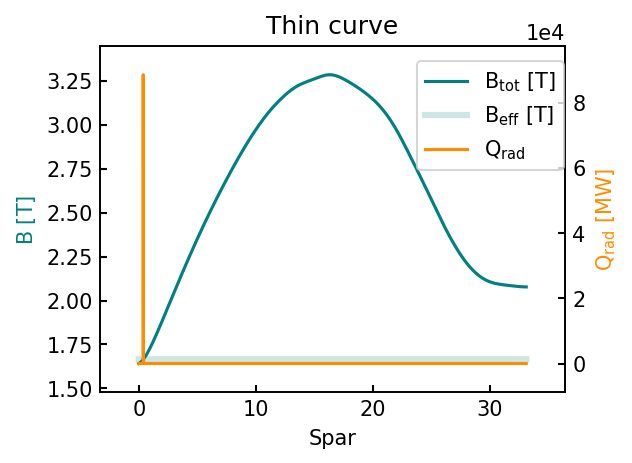

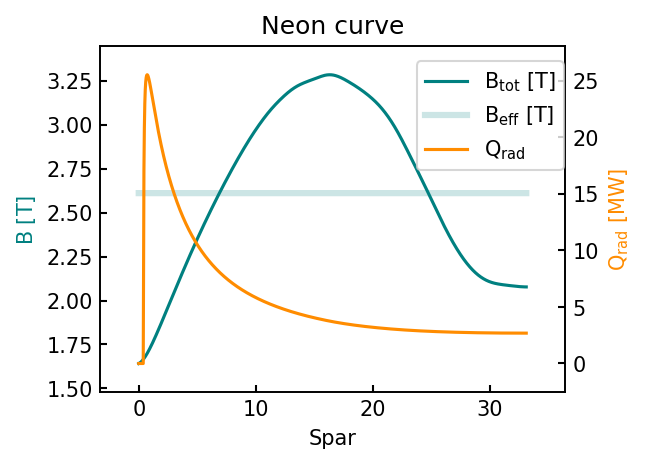

In [198]:
for name, out in cases.items():
    dls = out.data

    dls["Beff"] = np.sqrt(
        sp.integrate.trapezoid(y=dls["qpar"] * dls["Qrad"], x=dls["Spar"])
        / sp.integrate.trapezoid(y=dls["qpar"] * dls["Qrad"] / dls["Btot"]**2, x=dls["Spar"])
    )

    # dls["Beff"] = np.sqrt((dls["qpar"] * dls["Qrad"])) / np.sqrt((dls["qpar"] * dls["Qrad"] / dls["Btot"]**2))

    fig, ax = plt.subplots(figsize = (4,3), dpi = 150)

    ax.plot(dls["Spar"], dls["Btot"], label = r"$B_{tot}$ [T]")
    ax.plot(dls["Spar"], dls["Beff"], color = "teal", label = r"$B_{eff}$ [T]", lw = 3, alpha = 0.2)

    ax2 = ax.twinx()
    ax2.plot(dls["Spar"], dls["Qrad"]*1e-6, ls = "-", color = "darkorange", label = r"$Q_{rad}$")
    fig.legend(loc = "upper left", bbox_to_anchor = (0.65,0.85))
    ax.set_xlabel("Spar")
    ax.set_ylabel("$B$ [T]", color = "teal")
    ax2.set_ylabel("$Q_{rad}$ [MW]", color = "darkorange")
    ax.set_title(f"{name}")


Text(0, 0.5, '$T_{e}$ [eV]')

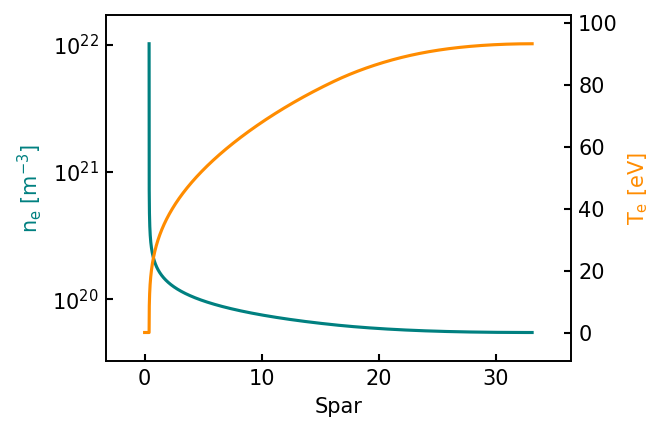

In [42]:
dls = cases["Thin curve"].data

fig, ax = plt.subplots(figsize = (4,3), dpi = 150)

ax.plot(dls["Spar"], dls["Ne"], label = r"$B_{tot}$ [T]")
ax.set_yscale("log")
# ax.plot(dls["Spar"], dls["Te"], color = "teal", label = r"$B_{eff}$ [T]", lw = 3, alpha = 0.2)

ax2 = ax.twinx()
ax2.plot(dls["Spar"], dls["Te"], ls = "-", color = "darkorange", label = r"$Q_{rad}$")

ax.set_xlabel("Spar")
ax.set_ylabel("$n_{e}$ [$m^{-3}$]", color = "teal")
ax2.set_ylabel("$T_{e}$ [eV]", color = "darkorange")
# ax.set_title(f"{name}")
# fig.legend(loc = "upper left", bbox_to_anchor = (0.65,0.85))

In [47]:
cases.keys()

dict_keys(['Thin curve', 'Neon curve'])

Text(0, 0.5, '$T_{e}$ [eV]')

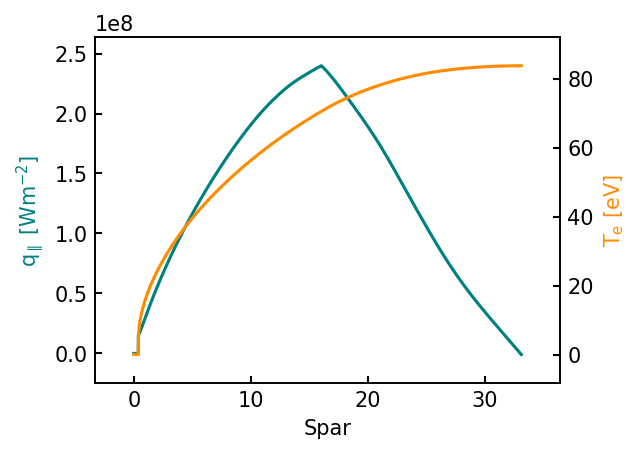

In [48]:
dls = cases["Neon curve"].data

fig, ax = plt.subplots(figsize = (4,3), dpi = 150)

ax.plot(dls["Spar"], dls["qpar"], label = r"$B_{tot}$ [T]")
# ax.set_yscale("log")
# ax.plot(dls["Spar"], dls["Te"], color = "teal", label = r"$B_{eff}$ [T]", lw = 3, alpha = 0.2)

ax2 = ax.twinx()
ax2.plot(dls["Spar"], dls["Te"], ls = "-", color = "darkorange", label = r"$Q_{rad}$")

ax.set_xlabel("Spar")
ax.set_ylabel(r"$q_{\parallel}$ [$Wm^{-2}$]", color = "teal")
ax2.set_ylabel("$T_{e}$ [eV]", color = "darkorange")
# ax.set_title(f"{name}")
# fig.legend(loc = "upper left", bbox_to_anchor = (0.65,0.85))

## Deep dive into scalings

### Debugging terms

In [ ]:
allterms = {}
terms = pd.DataFrame()
param = "Lc"
study_name = "Lc"

for curve_name in curves["set"].keys():
    profiles = store_profiles[study_name]
    stores = store_outer[study_name]
    
    store = stores[curve_name]
    names = list(store.keys())

    # Compare last and first case only!!
    df1 = DLScase(store[names[0]]).get_stats_dataframe()
    df2 = DLScase(store[names[-1]]).get_stats_dataframe()
    terms = pd.concat([df1, df2], axis = 0)
    terms.index = ["base", "test"]
    terms = terms.T
    terms = terms.loc[["Beff", "W_Tu", "int_TLz_dt", "int_qoverBsq_dt"],:]
    terms["ratio"] = terms["test"] / terms["base"]
    allterms[curve_name] = terms.copy()
    
    print(curve_name)
    display(terms)


SOLPS


,base,test,ratio
Beff,2.524755e+00,2.194245e+00,0.869092
W_Tu,1.825374e-01,1.402662e-01,0.768424
int_TLz_dt,1.264384e+12,1.247918e+12,0.986977
int_qoverBsq_dt,6.428822e+00,6.632497e+00,1.031681


Curve 1


,base,test,ratio
Beff,1.833435e+00,1.816788e+00,0.990920
W_Tu,1.724111e-01,1.374096e-01,0.796989
int_TLz_dt,7.628084e+12,7.768008e+12,1.018343
int_qoverBsq_dt,6.712429e+00,6.629385e+00,0.987628


Curve 2


,base,test,ratio
Beff,2.372208e+00,2.212314e+00,0.932597
W_Tu,1.809537e-01,1.415077e-01,0.782011
int_TLz_dt,1.386781e+12,1.250712e+12,0.901882
int_qoverBsq_dt,6.384594e+00,6.532351e+00,1.023143


Curve 3


,base,test,ratio
Beff,2.637184e+00,2.483448e+00,0.941705
W_Tu,1.907762e-01,1.462331e-01,0.766517
int_TLz_dt,1.102337e+12,8.945043e+11,0.811462
int_qoverBsq_dt,6.005550e+00,6.397781e+00,1.065311


## RESOLVE ANALYTICAL WITH UPSTREAM
- With upstream doesn't work

In [ ]:
analytical["Lc"]

,SOLPS,Curve 1,Curve 2,Curve 3
simple,0.285713,0.285713,0.285713,0.285713
simple_avgB,0.285706,0.285706,0.285706,0.285706
full,0.137256,0.137256,0.137256,0.137256


In [239]:
df = allsc["Curve 1"].terms_full.loc[["BxBt", "Lc", "avgB_ratio", "W_Tu_simple"]]
df.loc["BxBt", "factor"] = df["ratio"]["BxBt"]**(1)
df.loc["Lc", "factor"] = df["ratio"]["Lc"]**(2/7)
df.loc["avgB_ratio", "factor"] = df["ratio"]["avgB_ratio"]**(2/7)
df.loc["W_Tu_simple", "factor"] = df["ratio"]["W_Tu_simple"]**(-1)
df

,base,test,ratio,factor
BxBt,1.999993,3.999981,0.500001,0.500001
Lc,8.348459,8.348459,1.000000,1.000000
avgB_ratio,1.242008,1.412985,0.878996,0.963821
W_Tu_simple,0.347306,0.351230,0.988829,1.011298


In [242]:
store_outer[f"fR"]["Curve 1"].keys()

dict_keys([2, 4])

In [248]:
# Compare last and first case only!!
df1 = DLScase(store_outer[f"fR"]["Curve 1"][2]).get_stats_dataframe()
df2 = DLScase(store_outer[f"fR"]["Curve 1"][4]).get_stats_dataframe()
scaling = test_scalings(df1, df2, "BxBt", cumulative = True)

for col in scaling:
    if not any([name in col for name in ["result", "param_ratio"]]):
        scaling[col] = np.log(scaling[col]) / np.log(scaling["param_ratio"]) 
        
scaling

# for col in scaling.drop(["result", "param_ratio"], axis = 1).columns:
# exponents.loc[curve_name, col] = (np.log(1/scaling[col]) / np.log(scaling["param_ratio"])).values[0]

,result,param_ratio,simple_noavg_B,simple,abovex,Beff,W_Tu,curveclip,upstream_rad
0,0.51892,1.999997,-1.0,-0.946837,-0.930629,-0.939988,-0.92618,-0.925619,-0.925895


In [246]:
scaling

,result,param_ratio,simple_noavg_B,simple,abovex,Beff,W_Tu,curveclip,upstream_rad
0,0.51892,1.999997,0.500001,0.518769,0.52463,0.521238,0.52625,0.526455,0.526355


# Compare individual cases

In [ ]:
comps_outer["fR"]["Curve 1"][2].dls.keys()

Index(['Qrad', 'Spar', 'Spol', 'Te', 'qpar', 'Btot', 'cz', 'Ne', 'Xpoint',
       'qradial', 'Prad_per_area', 'Prad_per_area_cum',
       'Prad_per_area_cum_norm', 'Prad_cum', 'Prad_cum_norm', 'Pe', 'Ne_sq_cz',
       'qpar_cond_frac'],
      dtype='object')

## Why is Beff so weak for the inner?

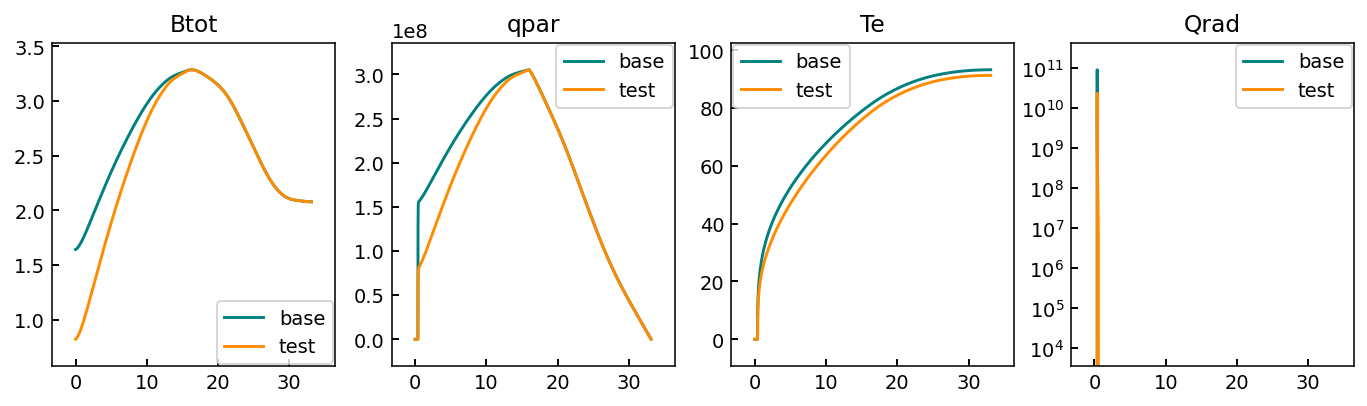

In [33]:
toplot = dict(
    base = comps_outer["fR"]["Thin"][2].dls,
    test = comps_outer["fR"]["Thin"][4].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## fR Curve 1

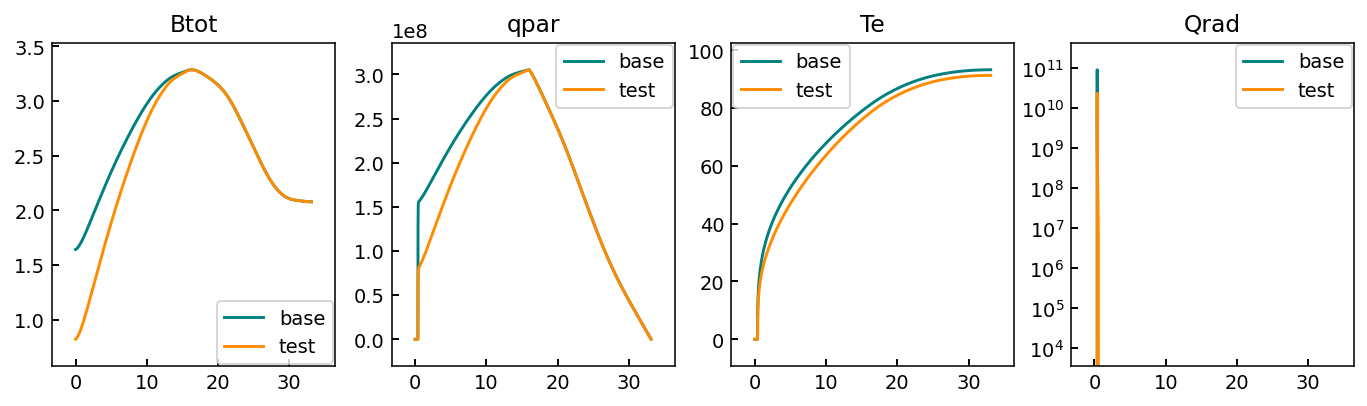

In [55]:

            
toplot = dict(
    base = comps_outer["fR"]["Thin"][2].dls,
    test = comps_outer["fR"]["Thin"][4].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## Thin curve and Lpar scaling

In [57]:
comps_outer["Lc"]["Thin"].keys()

dict_keys([1, 2])

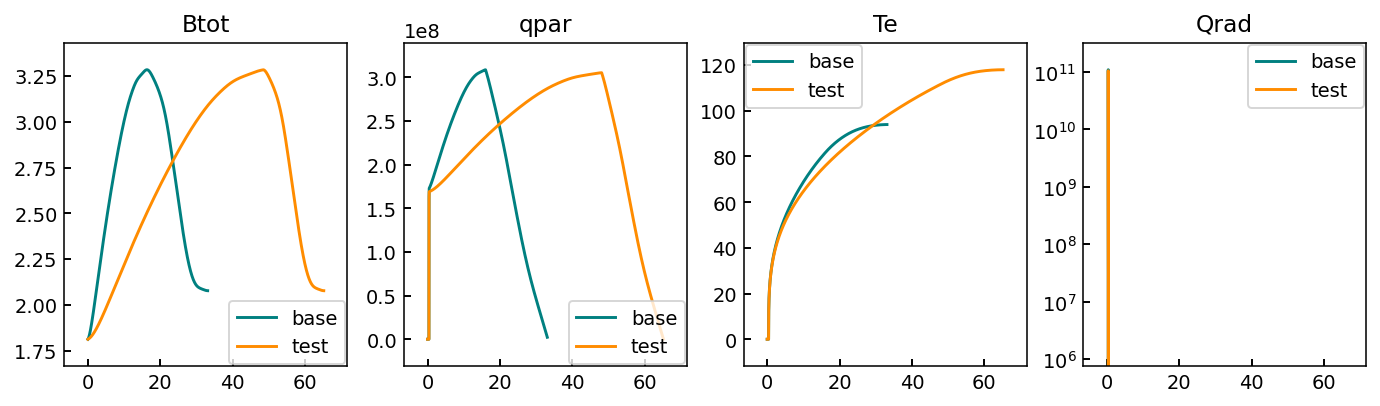

In [58]:
            
toplot = dict(
    base = comps_outer["Lc"]["Thin"][1].dls,
    test = comps_outer["Lc"]["Thin"][2].dls
)
params = ["Btot", "qpar", "Te", "Qrad"]

xlims_zoom = (0.25, 0.75)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## fR Curve 2

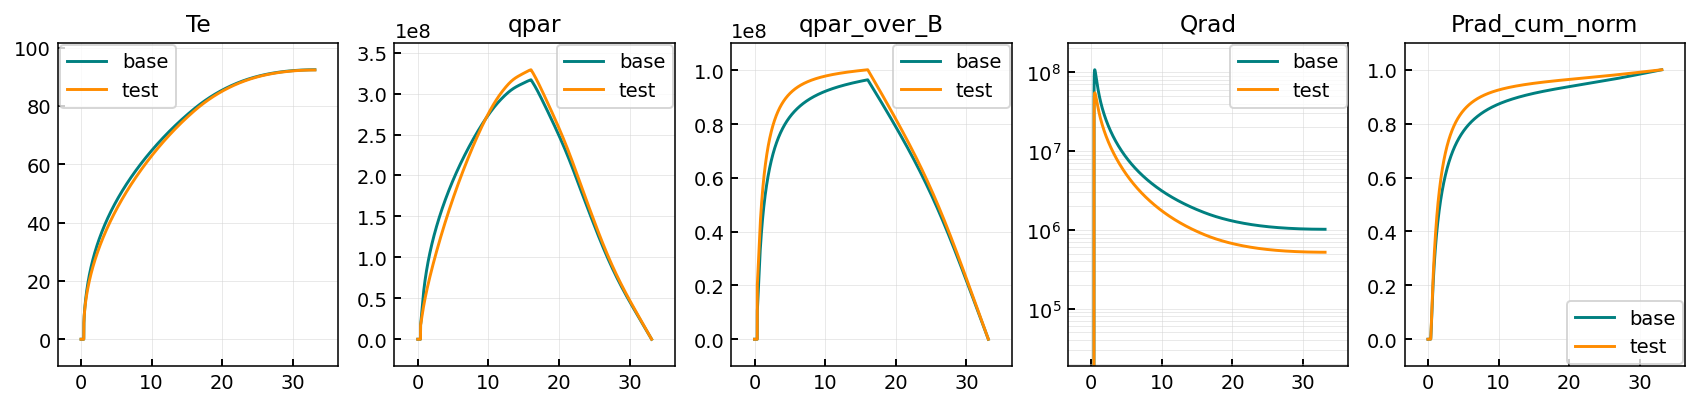

In [104]:
toplot = dict(
    base = comps_outer["fR"]["Curve 2"][2].dls,
    test = comps_outer["fR"]["Curve 2"][4].dls
)
params = ["Te", "qpar", "qpar_over_B", "Qrad", "Prad_cum_norm"]

xlims_zoom = (0, 35)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## fR Curve 3

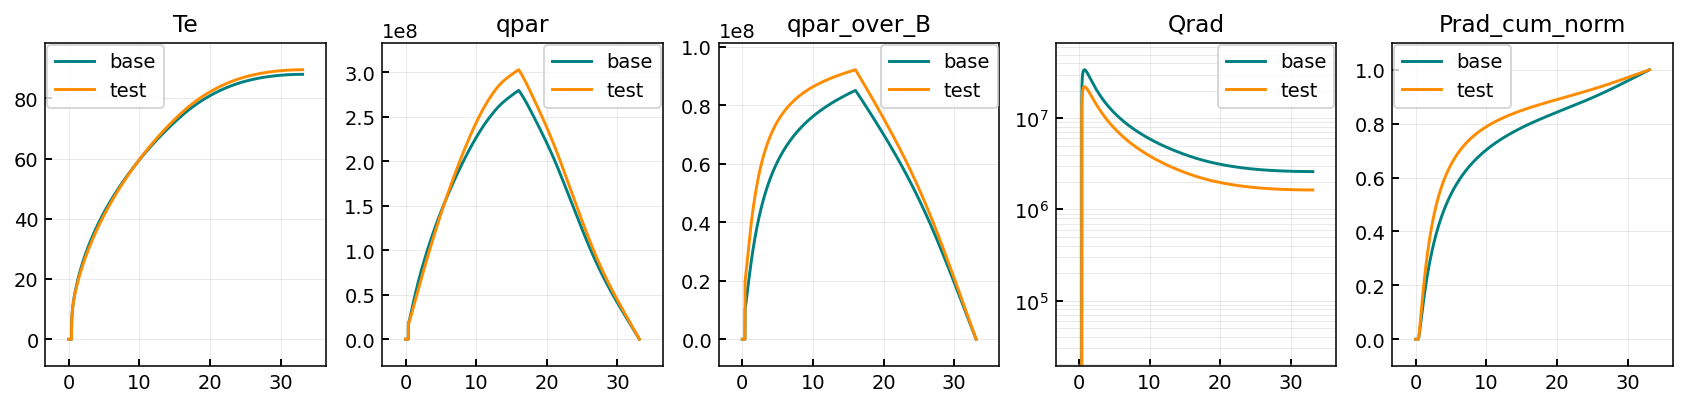

In [106]:
toplot = dict(
    base = comps_outer["fR"]["Curve 3"][2].dls,
    test = comps_outer["fR"]["Curve 3"][4].dls
)
params = ["Te", "qpar", "qpar_over_B", "Qrad", "Prad_cum_norm"]

xlims_zoom = (0, 35)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

## Inner: Lc Curve 1

In [141]:
comps_inner["Lc"]["Curve 1"].keys()

dict_keys([1, 1.5])

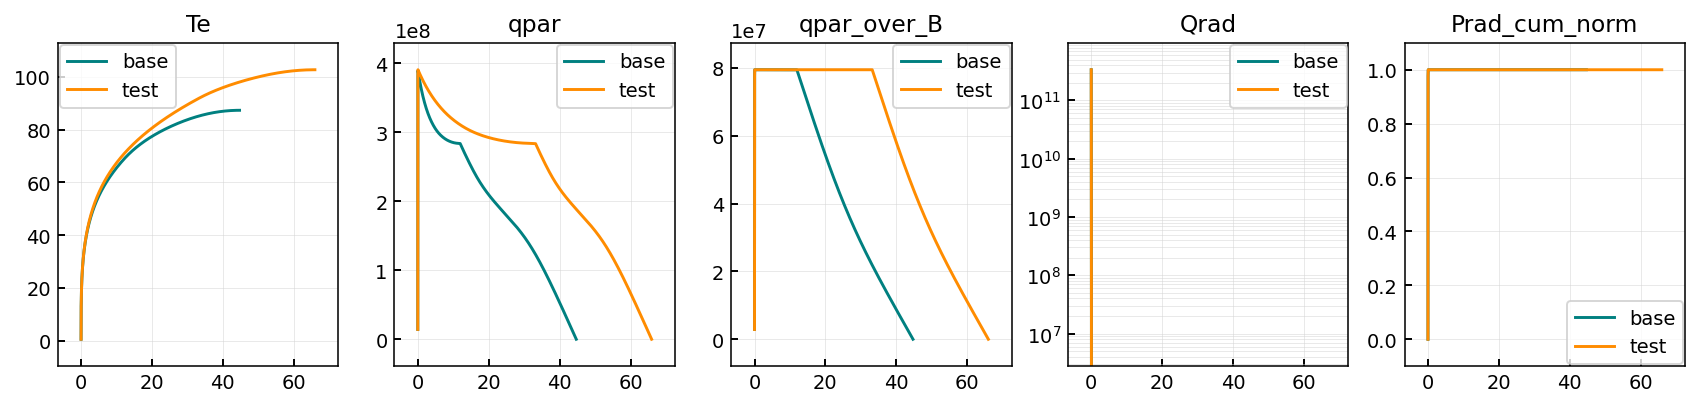

In [142]:
toplot = dict(
    base = comps_inner["Lc"]["Curve 1"][1].dls,
    test = comps_inner["Lc"]["Curve 1"][1.5].dls
)
params = ["Te", "qpar", "qpar_over_B", "Qrad", "Prad_cum_norm"]

xlims_zoom = (0, 35)
# xlims = dict(Qrad = xlims_zoom, Prad_per_area_cum_norm = xlims_zoom, Prad_cum_norm = xlims_zoom)
xlims = {}
scales = dict(Qrad = "log")

compare_dls(toplot, params, xlims = xlims, scales = scales)

# Front width evolution

## Front width: base

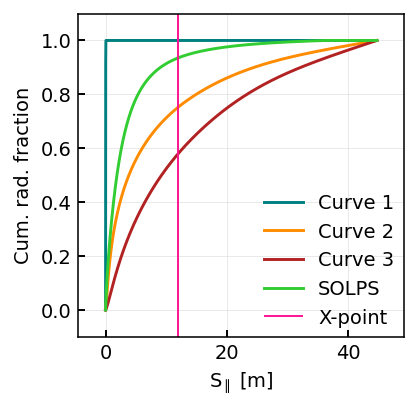

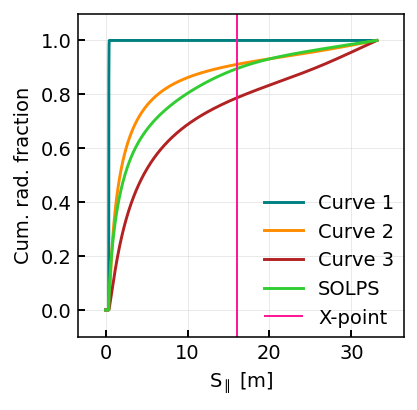

In [196]:
for side in ["inner", "outer"]: 

    fig, ax = plt.subplots(figsize = (3,3))

    for curve in curves[f"set_{side}"].keys():
        i = 1
        # for fR in store_profiles["fR"].keys():
        comp = comps[side]["Lc"][curve][i]
        dls = comp.dls
        ax.plot(dls["Spar"], dls["Prad_cum_norm"], label = curve)
        
    x = dls[dls["Xpoint"]==1].squeeze()
    ylim = ax.get_ylim()
    ax.vlines(x["Spar"], *ylim, lw = 1, color = "deeppink", label = "X-point")
    ax.set_ylim(ylim)
    ax.legend(frameon = False)
    ax.set_xlabel("$S_{\parallel}$ [m]")
    ax.set_ylabel("Cum. rad. fraction")

    # fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_frontwidths_{side}_lower.pdf", format = "pdf")

## Front width: base for synopsis

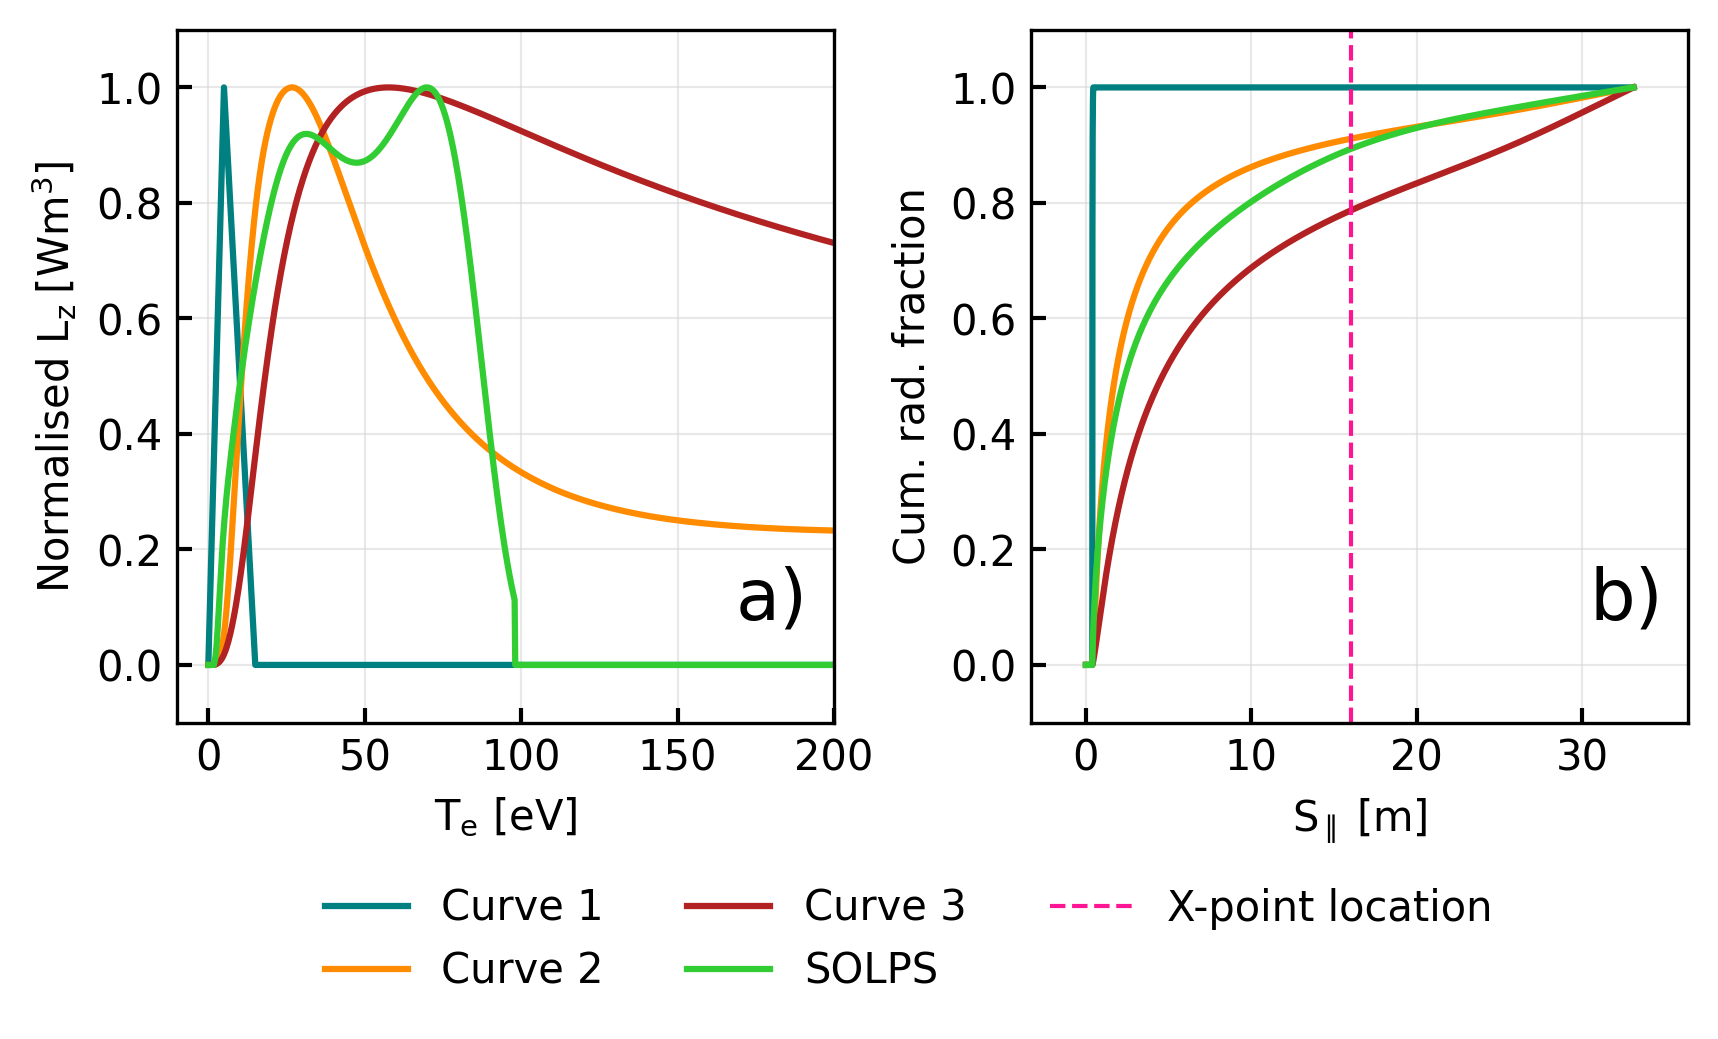

In [221]:
side = "outer"

fig, axes = plt.subplots(1,2, figsize = (6.5,3), dpi = 300)

for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    axes[0].plot(T, Lz, lw = 1.5)

axes[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
axes[0].set_xlabel("$T_e$ [eV]")
axes[0].set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
axes[0].set_xlim(-10,200)

for curve in curves[f"set_{side}"].keys():
    i = 1
    # for fR in store_profiles["fR"].keys():
    comp = comps_outer["Lc"][curve][i]
    dls = comp.dls
    axes[1].plot(dls["Spar"], dls["Prad_cum_norm"], label = curve)
    
x = dls[dls["Xpoint"]==1].squeeze()
ylim = axes[1].get_ylim()
axes[1].vlines(x["Spar"], *ylim, lw = 1, ls = "--", color = "deeppink", label = "X-point location")
axes[1].set_ylim(ylim)

axes[1].set_xlabel("$S_{\parallel}$ [m]")
axes[1].set_ylabel("Cum. rad. fraction")
axes[0].text(0.85,0.15,s = "a)", fontdict=dict(fontsize="xx-large"), transform = axes[0].transAxes)
axes[1].text(0.85,0.15,s = "b)", fontdict=dict(fontsize="xx-large"), transform = axes[1].transAxes)
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.05), ncol = 3, frameon = False)
fig.subplots_adjust(wspace = 0.3)
# fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_frontwidths_{side}_lower.pdf", format = "pdf")

## Front width: fR

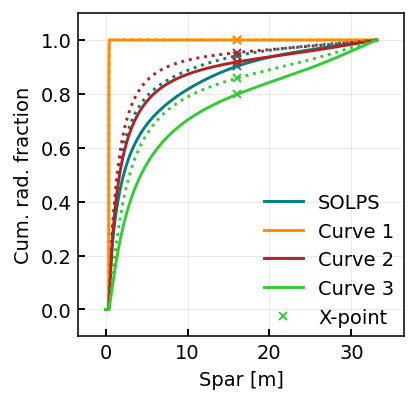

In [ ]:
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize = (3,3))

for i, curve in enumerate(curves["set"].keys()):

    # for fR in store_profiles["fR"].keys():
    comp = comps_outer["fR"][curve][2]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], label = curve)
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = colors[i], marker = "x", ms = 4, lw = 0, label = "X-point" if i == len(curves["set"])-1 else "")
    
    comp = comps_outer["fR"][curve][4]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], ls = ":")
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = colors[i], marker = "x", ms = 4, lw = 0)
    

ax.legend(frameon = False)
ax.set_xlabel("Spar [m]")
ax.set_ylabel("Cum. rad. fraction")
fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_fR_frontwidths.pdf", format = "pdf")


## Front width: Lc

Text(0.5, 1.0, 'Front widths before (solid) and after (dotted)')

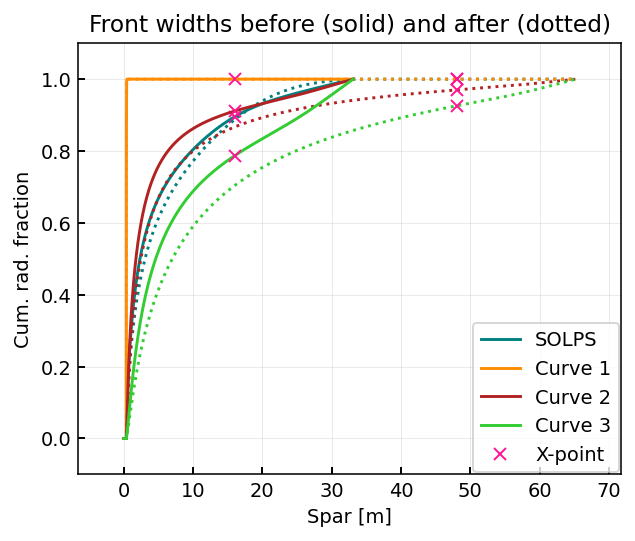

In [ ]:
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots()

for i, curve in enumerate(curves["set"].keys()):

    # for fR in store_profiles["fR"].keys():
    comp = comps_outer["Lc"][curve][1]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], label = curve)
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = "deeppink", marker = "x", ms = 6, lw = 0, label = "X-point" if i == len(curves["set"])-1 else "")
    
    comp = comps_outer["Lc"][curve][2]
    dls = comp.dls
    ax.plot(dls["Spar"], dls["Prad_cum_norm"], color = colors[i], ls = ":")
    dlsx = dls[dls["Xpoint"]==1].squeeze()
    ax.plot(dlsx["Spar"], dlsx["Prad_cum_norm"], color = "deeppink", marker = "x", ms = 6, lw = 0)
    
# x = dls[dls["Xpoint"]==1].squeeze()
# ylim = ax.get_ylim()
# ax.vlines(x["Spar"], *ylim, lw = 1, color = "deeppink", label = "X-point")
# ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel("Spar [m]")
ax.set_ylabel("Cum. rad. fraction")
ax.set_title("Front widths before (solid) and after (dotted)")


### wide_2 deep dive

Text(0.5, 1.04, 'wide_2')

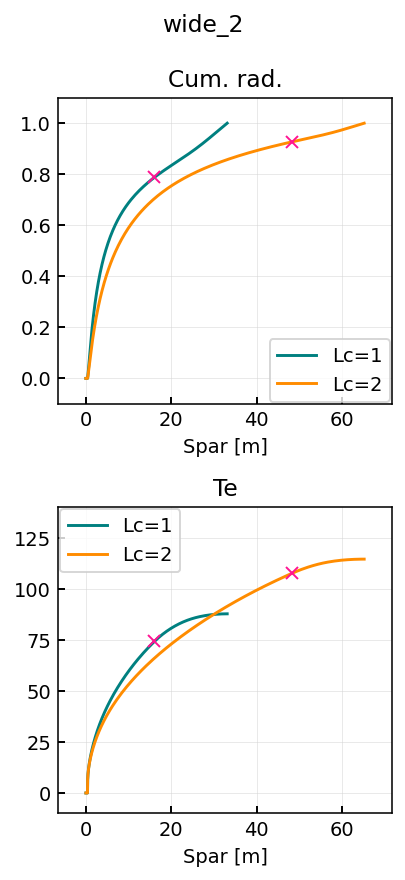

In [ ]:
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

curve = "wide_2"

fig, axes = plt.subplots(2,1, figsize = (3,6))

dfs = {1 : comps_outer["Lc"][curve][1].dls, 2 : comps_outer["Lc"][curve][2].dls}
xpoint_style = dict(lw = 0, marker = "x", ms = 6, c = "deeppink")

for Lc in dfs.keys():
    df = dfs[Lc]
    dfx = df[df["Xpoint"]==1].squeeze()
    axes[0].plot(df["Spar"], df["Prad_cum_norm"], label = f"Lc={Lc}")
    axes[0].plot(dfx["Spar"], dfx["Prad_cum_norm"], **xpoint_style)
    axes[1].plot(df["Spar"], df["Te"], label = f"Lc={Lc}")
    axes[1].plot(dfx["Spar"], dfx["Te"], **xpoint_style)
    
for ax in axes:
    ax.set_xlabel("Spar [m]")
    ax.legend()
    
axes[0].set_title("Cum. rad.")
axes[1].set_title("Te")
axes[1].set_ylim(-10, 140)
fig.tight_layout()
fig.suptitle(curve, y = 1.04)
# dls = comp.dls
# comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)



# Sensitivity

In [ ]:
sepadd_select.keys()

dict_keys(['outer_lower', 'inner_lower'])

## Run outer

In [109]:
sepadd = sepadd_select["outer_lower"]
profile = store_profiles["outer"][study][2]
store_scan_outer = {}

for curve_name in curves["set_outer"].keys():
    print("Solving curve", curve_name, "-----------------------------------------")
    Lfunc = curves["set_outer"][curve_name]
    
    # set switches
    radios_default = {
        "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    }

    df = slc.get_1d_poloidal_data(["Ne"], sepadd = sepadd, region = region, target_first = True)
    nu = df["Ne"].iloc[-1]

    # set general run parameters
    constants_default = {
        "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        "qpllu0": 3.42e8,
        "nu": nu,  # Upstream density (if constant)
        "nu0": nu,  # Upstream density (if constant)
        "cz0": 0.05,  # Impurity fraction (if constant)
        # "Lfunc": LfuncKallenbach("N"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        "Lfunc" : Lfunc,
        "kappa0" : 2800
    }

    SpolRange = np.linspace(0, profile["Spol"][profile["Xpoint"]], 10) # 
    SparRange = [profile["S"][np.argmin(np.abs(profile["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

    try: 
            out = run_dls(
                constants = constants_default, 
                radios = radios_default, 
                d = profile,
                SparRange = SparRange,
                control_variable = "density",
                verbosity = 0,
                Ctol = 1e-3,
                Ttol = 1e-3,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 5,
                dynamicGridRefinementWidth = 2,
                dynamicGridResolution = 10000,
                dynamicGridDiagnosticPlot = False)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)
        
    store_scan_outer[curve_name] = out


Solving curve Curve 1 -----------------------------------------
Solving...0.00...2.16...4.81...7.94...11.46...15.45...19.60...24.51...31.54...48.13...Complete in 12.1 seconds
Solving curve Curve 2 -----------------------------------------
Solving...0.00...2.16...4.81...7.94...11.46...15.45...19.60...24.51...31.54...48.13...Complete in 15.5 seconds
Solving curve Curve 3 -----------------------------------------
Solving...0.00...2.16...4.81...7.94...11.46...15.45...19.60...24.51...31.54...48.13...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 16.1 seconds
Solving curve SOLPS -----------------------------------------
Solving...0.00...2.16...4.81...7.94...11.46...15.45...19.60...24.51...31.54...48.13...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Complete in 20.6 seconds


## Run inner

In [127]:
sepadd = sepadd_select["inner_lower"]
profile = store_profiles["inner"][study][1]
store_scan_inner = {}

for curve_name in curves["set_inner"].keys():
    print("Solving curve", curve_name, "-----------------------------------------")
    Lfunc = curves["set_inner"][curve_name]
    
    # set switches
    radios_default = {
        "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    }

    df = slc.get_1d_poloidal_data(["Ne"], sepadd = sepadd, region = region, target_first = True)
    nu = df["Ne"].iloc[-1]

    # set general run parameters
    constants_default = {
        "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        "qpllu0": 3.42e8 * 0.83,
        "nu": nu,  # Upstream density (if constant)
        "nu0": nu,  # Upstream density (if constant)
        "cz0": 0.05,  # Impurity fraction (if constant)
        # "Lfunc": LfuncKallenbach("N"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        "Lfunc" : Lfunc,
        "kappa0" : 2800 * 1.73
    }

    SpolRange = np.linspace(0, profile["Spol"][profile["Xpoint"]], 10) # 
    SparRange = [profile["S"][np.argmin(np.abs(profile["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]

    try: 
            out = run_dls(
                constants = constants_default, 
                radios = radios_default, 
                d = profile,
                SparRange = SparRange,
                control_variable = "density",
                verbosity = 0,
                Ctol = 1e-3,
                Ttol = 1e-3,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 5,
                dynamicGridRefinementWidth = 2,
                dynamicGridResolution = 10000,
                dynamicGridDiagnosticPlot = False)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)
        
    store_scan_inner[curve_name] = out


Solving curve Curve 1 -----------------------------------------
Solving...0.00...0.51...1.08...1.71...2.44...3.46...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


4.56...5.99...8.25...11.95...Complete in 11.0 seconds
Solving curve Curve 2 -----------------------------------------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


0.51...1.08...1.71...2.44...3.46...4.56...5.99...8.25...11.95...Complete in 16.5 seconds
Solving curve Curve 3 -----------------------------------------
Solving...0.00...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


0.51...1.08...1.71...2.44...3.46...4.56...5.99...8.25...11.95...Complete in 16.9 seconds
Solving curve SOLPS -----------------------------------------
Solving...0.00...0.51...1.08...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


1.71...2.44...3.46...4.56...5.99...8.25...11.95...Complete in 14.1 seconds


# Absolute threshold change

In [115]:
region = "outer_lower"

sepadd = sepadd_select[region]

conditions = pd.DataFrame()

slc = store_slc[case]

df = slc.get_1d_poloidal_data(
    ["Te", "Ne", "Nn", "fAr", "RAr","Btot", "fhx_total", "vol", "Rd+_exiz", "Rd+_mol"], 
    sepadd = sepadd, region = region, target_first = True)

name = "mp_puff"
# df = df.iloc[:-1] ## Take out guards


df["hf_par_tot"] = df["fhx_total"] / df["apar"]
dfx = df[df["Xpoint"]==1].squeeze()


conditions.loc[name, "Nu"] = df.iloc[-1]["Ne"]

conditions.loc[name, "qpllu"] = abs(dfx["hf_par_tot"])
conditions.loc[name, "front_loc"] = slc.extract_front_pos(sepadd = sepadd, region = region, impurity = "Ar", method = "qpar_total", threshold = 0.05)
conditions.loc[name, "front_loc_Te5eV"] = slc.extract_front_pos(sepadd = sepadd, impurity = "Ar", region = region, method = "Te", threshold = 5)

## Make radiation weighted average Cz 
Lz = slc.extract_cooling_curve("Ar", region="outer_lower", sepadd = 4,order = 8)
Qn = [Lz(T) for T in df["Te"]]  # Cooling rate in Wm3
PN = df["RAr"]  # Radiation power source in Wm-3
Ptot = df["RAr"] + df["Rd+_exiz"] + df["Rd+_mol"]

df_over5eV = df[df["Te"]>5]
df_noneutrals = df[df["Nn"] < df["Ne"]*0.1]

conditions.loc[name, "cz_volavg"] = (df["fAr"] * df["vol"]).sum() / df["vol"].sum()
conditions.loc[name, "cz_rad_volavg"] = (PN * df["vol"]).sum() / (Qn * df["Ne"]**2 * df["vol"]).sum()
conditions.loc[name, "cz_radtot_volavg"] = (Ptot * df["vol"]).sum() / (Qn * df["Ne"]**2 * df["vol"]).sum()
conditions.loc[name, "cz_over5eV_volavg"] = (df_over5eV["fAr"] * df_over5eV["vol"]).sum() / df_over5eV["vol"].sum()
conditions.loc[name, "cz_noneutrals_volavg"] = (df_noneutrals["fAr"] * df_noneutrals["vol"]).sum() / df_noneutrals["vol"].sum()
conditions.loc[name, "cz_xpoint"] = dfx["fAr"]
    
for col in conditions.columns:
    if "cz" in col:
        conditions[col.replace("cz", "C")] = conditions[col]**(0.5) * conditions["Nu"] * conditions["qpllu"]**(-5/7)
        
for col in conditions.columns:
    if "cz" in col:        
        conditions[col.replace("cz", "Cnorm")] = conditions[col.replace("cz", "C")] / conditions[col.replace("cz", "C")].iloc[0]

# conditions_
# fig, ax = plt.subplots()
# ax.plot(conditions["cz_avg"], conditions["front_loc"])
display(conditions.T)

,mp_puff
Nu,2.426772e+19
qpllu,3.050983e+08
front_loc,3.829107e-01
front_loc_Te5eV,5.194994e-01
cz_volavg,2.750002e-02
cz_rad_volavg,4.228628e-02
cz_radtot_volavg,3.354293e-02
cz_over5eV_volavg,2.637155e-02
cz_noneutrals_volavg,2.711411e-02
cz_xpoint,2.108840e-02
